In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


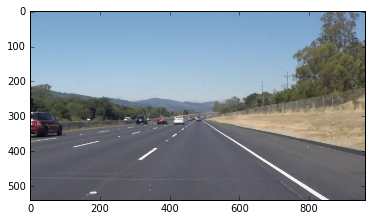

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color, thickness):
    
    fit_all = []
    total = 0
    number = 0
    left_fit_slope = []
    right_fit_slope = []
    left_fit_intercept = []
    right_fit_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            fit = np.polyfit((x1,x2),(y1,y2),1)
            fit_all.append(fit)
    
    for array in fit_all:
        total += array[0]
        number += 1
        
    average = total/number
    
    for array in fit_all:
        if array[0] <= average:
            left_fit_slope.append(array[0])
            left_fit_intercept.append(array[1])
        else:
            right_fit_slope.append(array[0])
            right_fit_intercept.append(array[1])
    
    leftslope = np.mean(left_fit_slope)
    leftintercept = np.mean(left_fit_intercept)
    
    rightslope = np.mean(right_fit_slope)
    rightintercept = np.mean(right_fit_intercept)

    x1_final_left = (540-leftintercept)/leftslope
    x1_final_left = math.floor(x1_final_left)
    y1_final_left = 540

    x2_final_left = (330-leftintercept)/leftslope
    x2_final_left = math.floor(x2_final_left)
    y2_final_left = 330

    x1_final_right = (540-rightintercept)/rightslope
    x1_final_right = math.floor(x1_final_right)
    y1_final_right = 540

    x2_final_right = (330-rightintercept)/rightslope
    x2_final_right = math.floor(x2_final_right)
    y2_final_right = 330
    
    
    #print (left_fit,right_fit)
    #print (x1_final_left, y1_final_left, x2_final_left, y2_final_left,x1_final_right,x2_final_right)

    cv2.line(img, (x1_final_left, y1_final_left), (x2_final_left, y2_final_left), color, thickness)
    cv2.line(img, (x1_final_right, y1_final_right), (x2_final_right, y2_final_right), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteCurve_result.png',
 'solidWhiteRight.jpg',
 'solidWhiteRight_result.png',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'SolidYellowCurve2_result.png',
 'SolidYellowCurve_result.png',
 'solidYellowLeft.jpg',
 'SolidYellowLeft_result.png',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitch_result.png']

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # Read in the image
    #image = mpimg.imread('test.jpg')
    # Read in the image and convert to grayscale

    #make a copy of image for Canny and final output
    Canny_copy=np.copy(image)
    raw_image = np.zeros_like(image)

    line_image = np.copy(image)*1 # creating a blank to draw lines on
    # *1 means that all numbers of pixels *1, which is the original number; also *0 means turning all pixels to black


    # Here we read a .p and convert to 0,255 bytescale
    gray = cv2.cvtColor(Canny_copy,cv2.COLOR_RGB2GRAY)


    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   


    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #print imshape for tracking
    #print('imshape is ',imshape)

    vertices = np.array([[(150,imshape[0]),(350,330), (550, 330), (1000,imshape[0])]], dtype=np.int32)
    #print vertices
    #print('vertices are: ',vertices)

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments


    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)

    draw_lines(raw_image,lines,[255,0,0],10)
    final_image = cv2.addWeighted(raw_image,0.9,line_image,1,0)  
    result=np.copy(final_image)
    
    return result


In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,3)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 34.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.04 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:23<00:00, 28.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 24.6 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 63%|██████████████████████████████████████████████████                              | 157/251 [00:10<00:06, 15.14it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))